In [2]:
import os
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import numpy as np
import pathlib

In [3]:
train_dir = 'chest_xray/train'  # Path to training dataset
val_dir = 'chest_xray/val'      # Path to validation dataset
test_dir = 'chest_xray/test'    # Path to test dataset

# Detect class names from the training directory
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.is_dir()]))
print("Classes detected:", class_names)

for c in class_names:
    count = len(list(pathlib.Path(train_dir).glob(f'{c}/*.jpeg')))
    print(f'{c}: {count} images')

Classes detected: ['NORMAL' 'PNEUMONIA']
NORMAL: 1341 images
PNEUMONIA: 3875 images


In [4]:
# Hyperparameters
batch_size = 32
img_size = 224

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Train size: 5216, Val size: 47, Test size: 624


In [5]:
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, 1, 1, 0, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))
        layers.append(nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.ReLU6(inplace=True))
        layers.append(nn.Conv2d(hidden_dim, out_channels, 1, 1, 0, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2, self).__init__()
        self.cfgs = [
            (1, 16, 1, 1),
            (6, 24, 2, 2),
            (6, 32, 3, 2),
            (6, 64, 4, 2),
            (6, 96, 3, 1),
            (6, 160, 3, 2),
            (6, 320, 1, 1),
        ]
        input_channel = 32
        last_channel = 1280

        self.features = [nn.Conv2d(3, input_channel, 3, 2, 1, bias=False),
                         nn.BatchNorm2d(input_channel),
                         nn.ReLU6(inplace=True)]
        for t, c, n, s in self.cfgs:
            output_channel = c
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(InvertedResidual(input_channel, output_channel, stride, t))
                input_channel = output_channel
        self.features.append(nn.Conv2d(input_channel, last_channel, 1, 1, 0, bias=False))
        self.features.append(nn.BatchNorm2d(last_channel))
        self.features.append(nn.ReLU6(inplace=True))
        self.features = nn.Sequential(*self.features)

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x

num_classes = len(class_names)
model = MobileNetV2(num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [8]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(epoch, model, loader, optimizer, criterion):
    model.train()
    running_loss = 0; correct = 0; total = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0; correct = 0; total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    train_loss, train_acc = train_one_epoch(epoch, model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Acc {train_acc:.4f}; Val Loss {val_loss:.4f}, Acc {val_acc:.4f}")


Epoch 1: Train Loss 0.4015, Acc 0.8250; Val Loss 0.4674, Acc 0.7660
Epoch 2: Train Loss 0.3492, Acc 0.8470; Val Loss 0.4616, Acc 0.7872
Epoch 3: Train Loss 0.3478, Acc 0.8512; Val Loss 0.4829, Acc 0.8085
Epoch 4: Train Loss 0.3248, Acc 0.8635; Val Loss 0.4682, Acc 0.6809
Epoch 5: Train Loss 0.3121, Acc 0.8673; Val Loss 0.6337, Acc 0.7021
Epoch 6: Train Loss 0.2960, Acc 0.8760; Val Loss 0.8349, Acc 0.6809
Epoch 7: Train Loss 0.2888, Acc 0.8794; Val Loss 0.5177, Acc 0.8723
Epoch 8: Train Loss 0.2798, Acc 0.8823; Val Loss 0.4536, Acc 0.8723
Epoch 9: Train Loss 0.2812, Acc 0.8838; Val Loss 0.4305, Acc 0.8723
Epoch 10: Train Loss 0.2600, Acc 0.8928; Val Loss 0.4294, Acc 0.8298


In [9]:
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}; Test Accuracy: {test_acc:.4f}")




Test Loss: 0.3075; Test Accuracy: 0.9006


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       234
           1       0.91      0.93      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



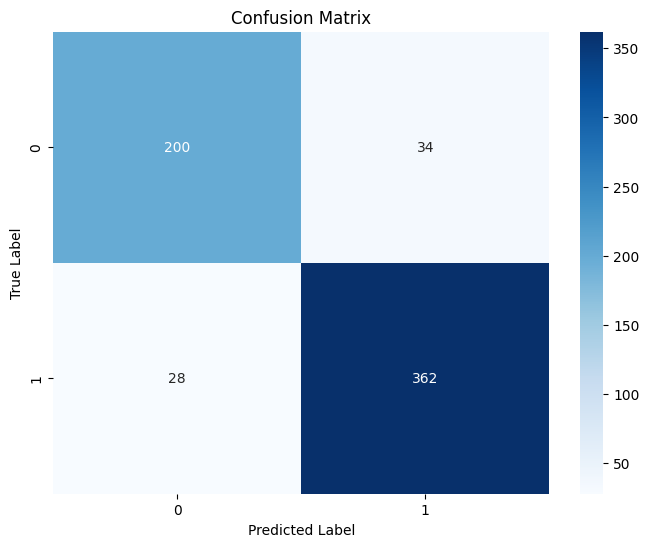

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions for classification report
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Generate and visualize confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(len(np.unique(all_labels))), 
            yticklabels=range(len(np.unique(all_labels))))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


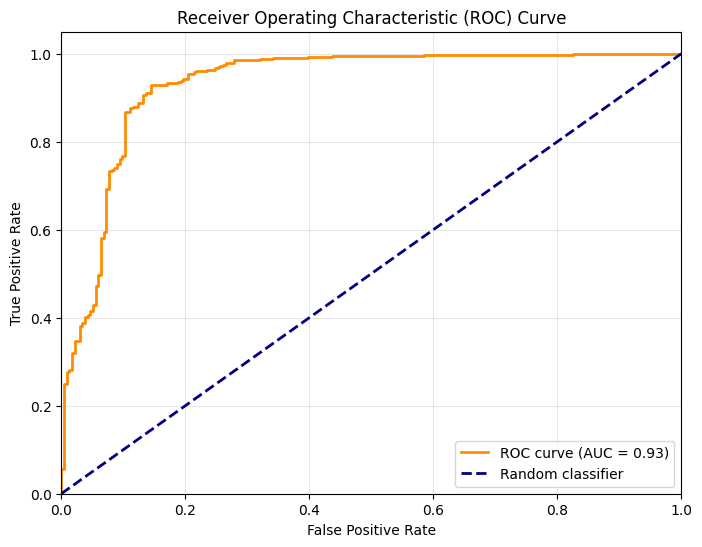


AUC Score: 0.9326


In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Get prediction probabilities for ROC curve
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Get number of classes
n_classes = len(np.unique(all_labels))

# Handle binary classification case
if n_classes == 2:
    # For binary classification, use the positive class probabilities
    y_test_bin = all_labels
    pos_probs = all_probs[:, 1]  # probabilities for positive class
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test_bin, pos_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"\nAUC Score: {roc_auc:.4f}")

else:
    # For multiclass classification
    # Binarize the labels for multiclass ROC
    y_test_bin = label_binarize(all_labels, classes=range(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot individual ROC curves for each class
    fig, axes = plt.subplots(2, (n_classes + 1) // 2, figsize=(15, 10))
    axes = axes.flatten() if n_classes > 2 else [axes]
    
    colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
    
    for i in range(n_classes):
        ax = axes[i] if n_classes > 1 else axes
        ax.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                label=f'ROC curve (AUC = {roc_auc[i]:.2f})')
        ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random classifier')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - Class {i}')
        ax.legend(loc="lower right")
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots if odd number of classes
    if n_classes % 2 == 1 and n_classes > 1:
        axes[-1].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Plot combined ROC curves
    plt.figure(figsize=(10, 8))
    
    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    
    # Plot ROC curve for each class
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve class {i} (AUC = {roc_auc[i]:.2f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Combined ROC Curves - All Classes')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print AUC scores
    print("\nAUC Scores:")
    for i in range(n_classes):
        print(f"Class {i}: {roc_auc[i]:.4f}")
    print(f"Micro-average: {roc_auc['micro']:.4f}")


In [17]:
# Optionally, save the model
torch.save(model.state_dict(), 'mobilenetv2_chestxray.pth')